In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
pd.set_option('display.max_columns' , None)
pd.set_option('display.max_rows' , None)

In [3]:
Path_train = 'adult_train.csv'
adult_data_df = pd.read_csv(Path_train)
adult_data = [adult_data_df]

# adult_data_df.head(3)

In [4]:
Path_test = 'adult_test.csv'
adult_data_df_test = pd.read_csv(Path_test)
adult_data_test = [adult_data_df_test]

# adult_data_df_test.head(10)

Stage One: Data Preprocessing

In [5]:
# # 載入數據集
# train_df = adult_data_df
# test_df = adult_data_df_test

# # 分離特徵和標籤
# X_train = train_df.drop('hrs-per-week', axis=1)
# y_train = train_df['hrs-per-week']
# X_test = test_df.drop('hrs-per-week', axis=1)
# y_test = test_df['hrs-per-week']


# 載入數據
train_df = pd.read_csv(Path_train)
test_df = pd.read_csv(Path_test)

# 分離特徵和標籤
X_train = train_df.drop('hrs-per-week', axis=1)
y_train = train_df['hrs-per-week']
X_test = test_df.drop('hrs-per-week', axis=1)
y_test = test_df['hrs-per-week']

# 重新定義數值和分類特徵列
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# 建立數值和分類特徵的處理管道
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 結合特徵處理
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 應用預處理
X_train = preprocessor.fit_transform(train_df.drop('hrs-per-week', axis=1))
y_train = train_df['hrs-per-week']
X_test = preprocessor.transform(test_df.drop('hrs-per-week', axis=1))
y_test = test_df['hrs-per-week']

SVD

In [6]:
from sklearn.decomposition import TruncatedSVD

# 使用 TruncatedSVD 進行降維，初始不指定成分數量
svd = TruncatedSVD(n_components=min(X_train.shape) - 1)
svd.fit(X_train)

# 計算累積方差解釋率
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# 找到解釋至少 95% 方差的成分數量
n_components = np.where(cumulative_variance >= 0.95)[0][0] + 1

# 重新應用 TruncatedSVD 並保留找到的成分數量
svd = TruncatedSVD(n_components=n_components)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

print("選擇的成分數量:", n_components)


選擇的成分數量: 34


In [7]:
from sklearn.decomposition import TruncatedSVD

# 初始化 TruncatedSVD
svd = TruncatedSVD(n_components=n_components)

# 對訓練數據應用 TruncatedSVD
X_train_svd = svd.fit_transform(X_train)

# 對測試數據應用相同的轉換
X_test_svd = svd.transform(X_test)

# 打印結果
print("原始訓練數據的形狀:", X_train.shape)
print("降維後訓練數據的形狀:", X_train_svd.shape)
print("原始測試數據的形狀:", X_test.shape)
print("降維後測試數據的形狀:", X_test_svd.shape)

原始訓練數據的形狀: (32561, 109)
降維後訓練數據的形狀: (32561, 34)
原始測試數據的形狀: (16281, 109)
降維後測試數據的形狀: (16281, 34)


Stage Two: Model Training and Evaluation (Approximately takes 1 minute and 8.3 seconds on an I5-10400)

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import time

# 初始化模型
models = {
    'KNN': KNeighborsRegressor(),
    'SVR': SVR(),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror')
}


# 更新的訓練和評估函數，包括計時
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time() # 訓練開始時間
    model.fit(X_train, y_train)
    end_time = time.time() # 訓練結束時間
    training_time = end_time - start_time # 計算訓練時間
    
    start_time = time.time() # 預測開始時間
    predictions = model.predict(X_test)
    end_time = time.time() # 預測結束時間
    prediction_time = end_time - start_time # 計算預測時間
    
    # 計算評估指標
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, predictions)
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Training Time': training_time,
        'Prediction Time': prediction_time
    }

# 重新訓練和評估每個模型，並記錄時間
models_performance = {}
for name, model in models.items():
    performance = train_evaluate_model(model, X_train, y_train, X_test, y_test)
    models_performance[name] = performance

# 顯示模型效能和時間
for name, performance in models_performance.items():
    print(f'{name} performance: {performance}')

KNN performance: {'MAE': 8.097598427615011, 'MSE': 134.72630182421227, 'RMSE': 11.607165968668333, 'R2': 0.13484012415747482, 'Training Time': 0.0019981861114501953, 'Prediction Time': 14.034024477005005}
SVR performance: {'MAE': 6.941700173973376, 'MSE': 122.85305466950288, 'RMSE': 11.083909719476376, 'R2': 0.21108549640571617, 'Training Time': 88.65328764915466, 'Prediction Time': 31.10399889945984}
RandomForest performance: {'MAE': 7.680089241476334, 'MSE': 123.45158660759947, 'RMSE': 11.110876950430127, 'R2': 0.20724195724342942, 'Training Time': 257.6560733318329, 'Prediction Time': 0.41297149658203125}
XGBoost performance: {'MAE': 7.3544156719620375, 'MSE': 115.51599961095155, 'RMSE': 10.747836973593875, 'R2': 0.2582012084645865, 'Training Time': 0.17299723625183105, 'Prediction Time': 0.011001348495483398}


In [9]:
# 顯示數據集大小
print("訓練集大小 (行數, 列數):", train_df.shape)
print("測試集大小 (行數, 列數):", test_df.shape)

# 顯示數據集大小
print("訓練集大小 (行數, 列數):", X_train.shape)
print("測試集大小 (行數, 列數):", X_test.shape)
print("訓練集大小 (行數, 列數):", y_train.shape)
print("測試集大小 (行數, 列數):", y_test.shape)

訓練集大小 (行數, 列數): (32561, 15)
測試集大小 (行數, 列數): (16281, 15)
訓練集大小 (行數, 列數): (32561, 109)
測試集大小 (行數, 列數): (16281, 109)
訓練集大小 (行數, 列數): (32561,)
測試集大小 (行數, 列數): (16281,)


Generate a comparison chart of execution times.

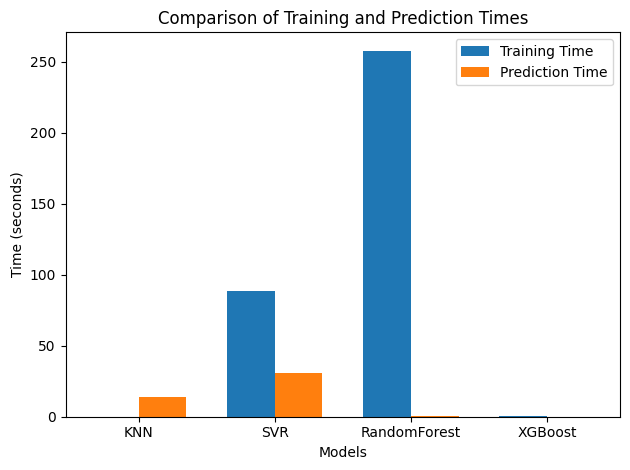

In [12]:
import matplotlib.pyplot as plt

# 演算法的名稱
model_names = list(models_performance.keys())

# 訓練時間和預測時間
training_times = [models_performance[model]['Training Time'] for model in model_names]
prediction_times = [models_performance[model]['Prediction Time'] for model in model_names]

# 設定條形圖寬度
bar_width = 0.35

# 生成索引
index = range(len(model_names))

# 訓練時間條形圖
plt.bar(index, training_times, bar_width, label='Training Time')

# 預測時間條形圖，將條形圖向右移動一個寬度
plt.bar([i + bar_width for i in index], prediction_times, bar_width, label='Prediction Time')

# 添加標籤和標題
plt.xlabel('Models')
plt.ylabel('Time (seconds)')
plt.title('Comparison of Training and Prediction Times')
plt.xticks([i + bar_width / 2 for i in index], model_names)

# 添加圖例
plt.legend()

# 顯示圖表
plt.tight_layout()
plt.show()


Generate comparison charts for various metrics.

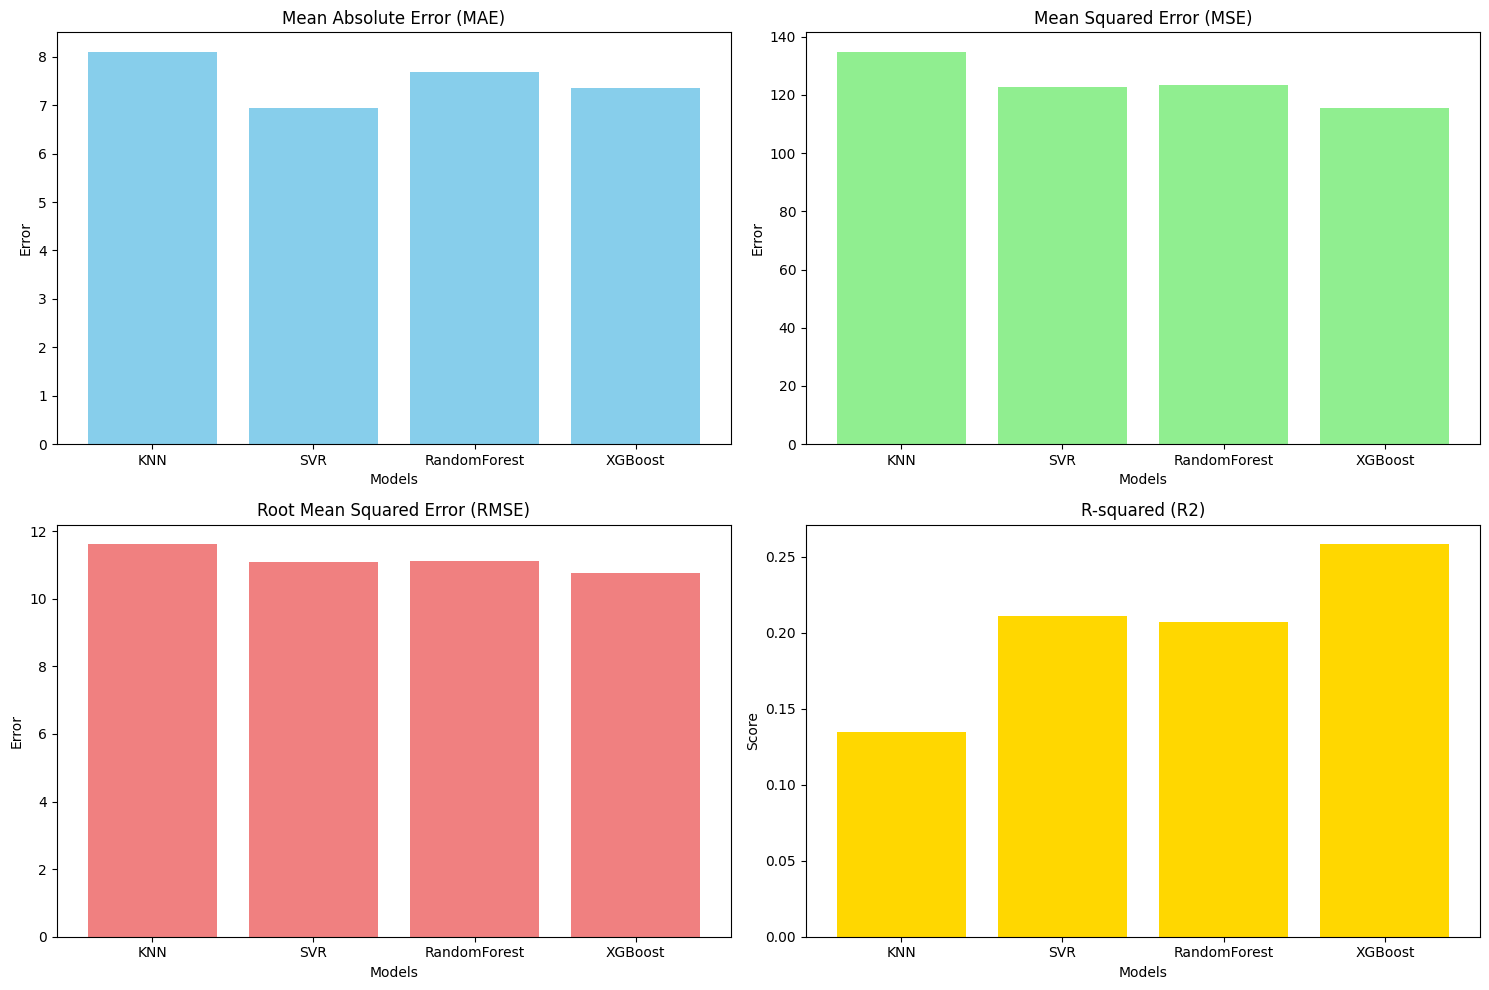

In [13]:
# 繪製比較指標的圖表
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# MAE 比較
axs[0, 0].bar(model_names, [models_performance[model]['MAE'] for model in model_names], color='skyblue')
axs[0, 0].set_title('Mean Absolute Error (MAE)')
axs[0, 0].set_ylabel('Error')

# MSE 比較
axs[0, 1].bar(model_names, [models_performance[model]['MSE'] for model in model_names], color='lightgreen')
axs[0, 1].set_title('Mean Squared Error (MSE)')
axs[0, 1].set_ylabel('Error')

# RMSE 比較
axs[1, 0].bar(model_names, [models_performance[model]['RMSE'] for model in model_names], color='lightcoral')
axs[1, 0].set_title('Root Mean Squared Error (RMSE)')
axs[1, 0].set_ylabel('Error')

# R2 比較
axs[1, 1].bar(model_names, [models_performance[model]['R2'] for model in model_names], color='gold')
axs[1, 1].set_title('R-squared (R2)')
axs[1, 1].set_ylabel('Score')

# 設定 x 軸標籤
for ax in axs.flat:
    ax.set_xlabel('Models')

# 調整每個 subplot 間距
plt.tight_layout()

# 顯示圖表
plt.show()
